In [ ]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import cv2
from torchvision.utils import save_image
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable
import seaborn as sns;sns.set()
from torchsummary import summary
!pip install livelossplot
from livelossplot import PlotLosses
torch.manual_seed(0)

## step3: Auto encoder
1. Autoencoder1 with Linear dimension reduction
- layer 5개
- INPUT - linear - **H1** - linear - *H2(latent)* -  linear - **H3** - OUTPUT

2. Autoencoder2 with nonlinear(PReLU) dimension reduction
- layer 7개
- INPUT - linear - PReLU - **H1** - linear -  PReLU - **H2** -  linear - **H3(latent)** - linear - **H4** -  PReLU - linear - **H5** -  PReLU - linear - OUTPUT

3. Autoencoder3 based on deep CNN with tanh

4. Autoencoder4 based on deep CNN with sigmoid
- decoding의 마지막 activation function만 변경


## training 준비

In [ ]:
# hyperparameter
batch_size = 20

In [ ]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])

In [ ]:
patch_train_dataset = ImageFolder(root= "./data/nocrop/patch/train", transform=transform)
patch_train_loader = torch.utils.data.DataLoader(patch_train_dataset, shuffle=False, batch_size=batch_size)

In [ ]:
# validation data for training(only nodefect)
patch_val_dataset = ImageFolder(root= "./data/nocrop/patch/val_for_training", transform=transform)
patch_val_loader = torch.utils.data.DataLoader(patch_val_dataset,  shuffle=False, batch_size=batch_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

## modeling

In [ ]:
class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64*64, 1000),
            nn.Linear(1000, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 1000),
            nn.Linear(1000, 64*64) 
        )        
    def forward(self,x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(x.size(0), 1, 64, 64)
        return out

model1 = Autoencoder1().to(device)

In [ ]:
print(Autoencoder1().cuda())

In [ ]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64*64, 32*32),
            nn.PReLU(32*32),
            nn.Linear(32*32, 16*16),
            nn.PReLU(16*16),
            nn.Linear(16*16,4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 16*16),
            nn.PReLU(16*16),
            nn.Linear(16*16, 32*32),
            nn.PReLU(32*32),
            nn.Linear(32*32, 64*64)
        )   
                
    def forward(self,x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
       # out = self.decoder(encoded)
        out = self.decoder(encoded).view(x.size(0), 1, 64, 64)
        return out

model2 = Autoencoder2().to(device)

In [ ]:
print(Autoencoder2().cuda())

In [ ]:
class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3,self).__init__()
        self.encoder = nn.Sequential (
          # conv 1
          nn.Conv2d(in_channels= 1, out_channels=16, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # # conv 2
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 3
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(64),

          # # conv 4
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(128),

          # # conv 5
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(256)
        )

        self.decoder = nn.Sequential (
          # # conv 6
          nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(128),

          # # conv 7
          nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(64),

          # # conv 8
          nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 9
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # conv 10
          nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),
          nn.Tanh()
        )

    def forward(self, x):
      encoded = self.encoder(x)
      out = self.decoder(encoded).view(x.size(0), 1, 64, 64)
      return out

model3 = Autoencoder3().to(device)

In [ ]:
summary(model3,(1,64,64))

print(Autoencoder3().cuda())

In [ ]:
class Autoencoder4(nn.Module):
    def __init__(self):
        super(Autoencoder4,self).__init__()
        self.encoder = nn.Sequential (
          # conv 1
          nn.Conv2d(in_channels= 1, out_channels=16, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # # conv 2
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 3
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(64),

          # # conv 4
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(128),

          # # conv 5
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(256)
        )

        self.decoder = nn.Sequential (
          # # conv 6
          nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(128),

          # # conv 7
          nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(64),

          # # conv 8
          nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 9
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # conv 10
          nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),
          nn.Sigmoid()
        )

    def forward(self, x):
      encoded = self.encoder(x)
      out = self.decoder(encoded).view(x.size(0), 1, 64, 64)
      return out

model4 = Autoencoder4().to(device)      

In [ ]:
summary(model4,(1,64,64))

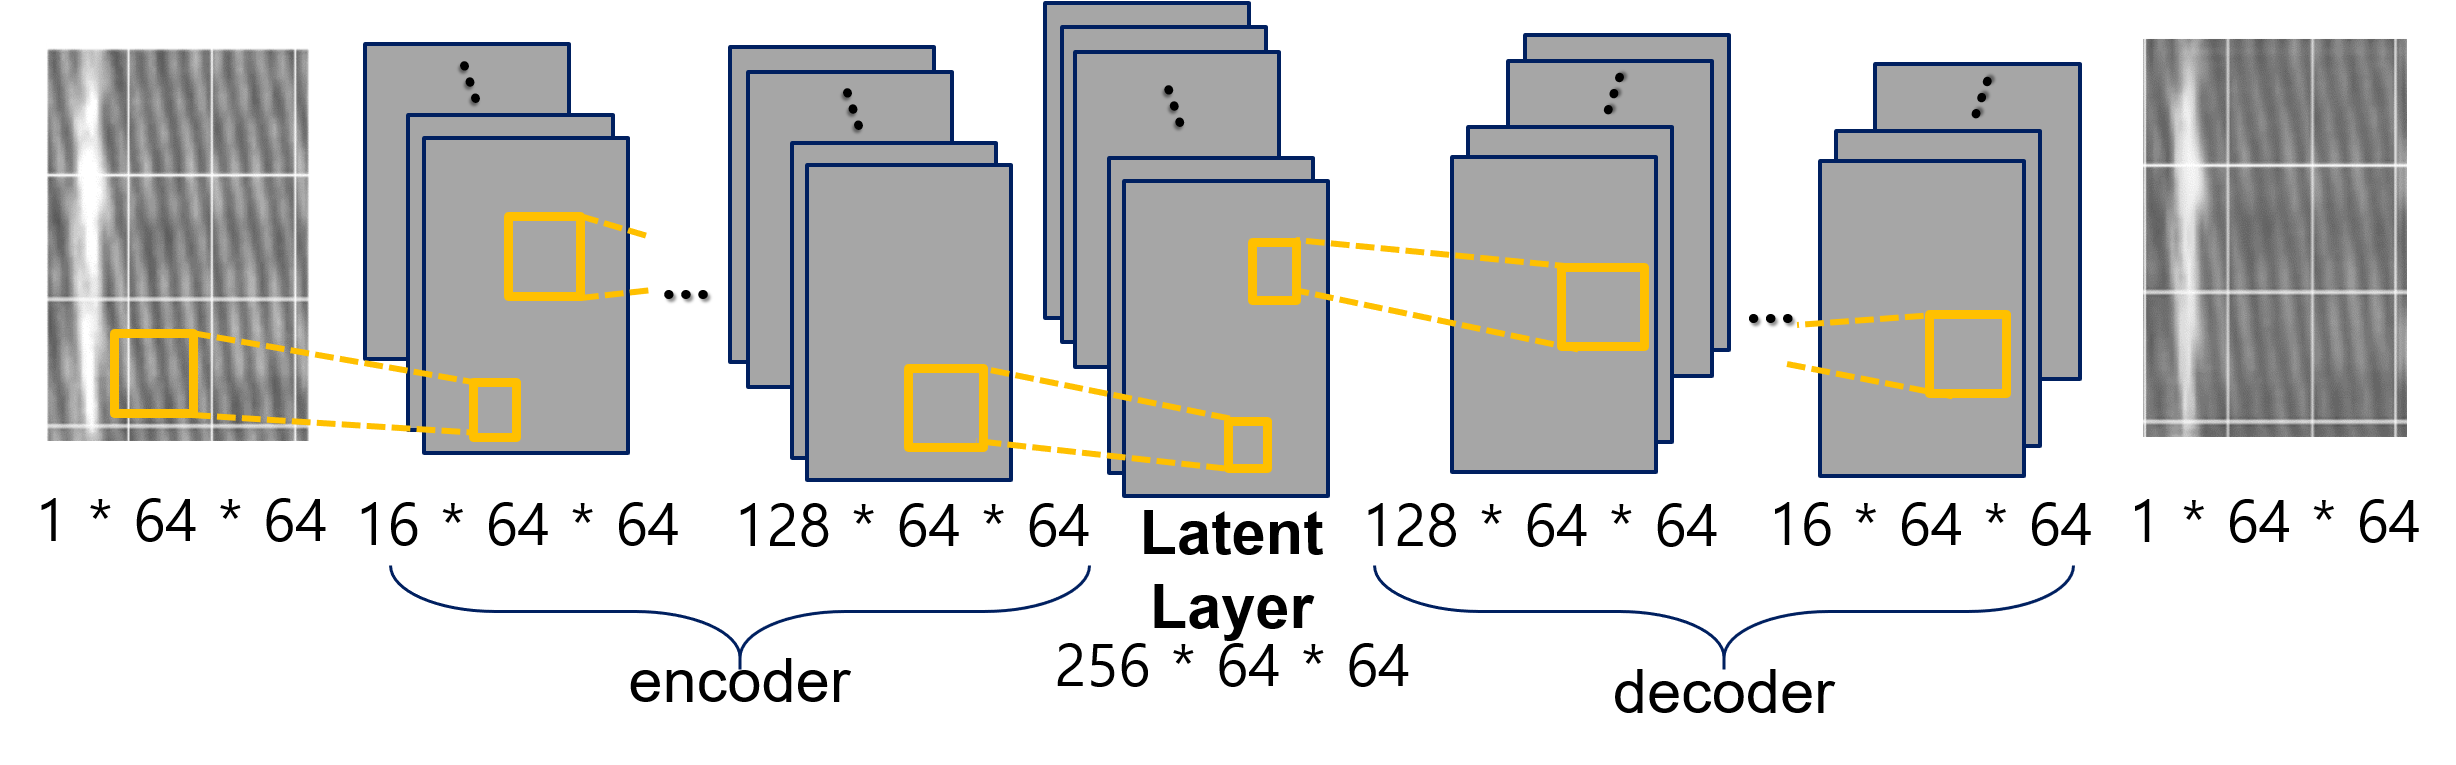

In [2]:
from IPython.display import Image
Image('model-architecture.png')

In [ ]:
## model 3,4 와 다르게 stride를 1 대신 3과 2로 설정하여 시도해보았다.
## 결과적으로는 이미지 재구성력이 떨어지므로
## 휴리스틱한 방법으로 모델 채택하지 않음
class Autoencoder5(nn.Module):
    def __init__(self):
        super(Autoencoder5,self).__init__()
        self.encoder = nn.Sequential (
          # conv 1
          nn.Conv2d(in_channels= 1, out_channels=16, kernel_size=3, stride=3, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # # conv 2
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=3, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 3
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(64)
        )

        self.decoder = nn.Sequential (
          # # conv 4
          nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 5
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=3, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # conv 5
          nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=3, padding=1),
          nn.Sigmoid()
        )

    def forward(self, x):
      encoded = self.encoder(x)
      out = self.decoder(encoded).view(x.size(0), 1, 64, 64)
      return out

model5 = Autoencoder5().to(device)      

In [ ]:
summary(model5,(1,64,64))

### training
- autoencoder1, 2, 3, 4 모델을 gdrive에 .pth형태로 save.

In [ ]:
def train(model, patch_train_loader, patch_val_loader, EPOCHS, learning_rate):
  loss_func = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.99)
  liveloss = PlotLosses()
  lr2_tr_loss = []
  lr2_val_loss = []
  model_losses, valid_losses = [], []
      
  for epoch in range(EPOCHS):
    print("epoch{}".format(epoch))
    model_losses, valid_losses = [], []
    logs = {}
    prefix = ''
      
    # with train data
    model.train()
    for idx, (data,target) in enumerate(patch_train_loader):
        data = torch.autograd.Variable(data).to(device = device, dtype = torch.float)
        print(data.shape)
        optimizer.zero_grad()
        pred = model(data)
        print(pred.shape)
        loss = loss_func(pred, data)
        # Backpropagation
        loss.backward()
        # update
        optimizer.step()
        # loss save
        model_losses.append(loss.cpu().data.item())
        logs[prefix + 'MSE loss'] = loss.item()
        print(idx,"complete")
          
    ## with validation data(only nodefect)
    model.eval()
    for idx, (data,target) in enumerate(patch_val_loader):
        data = torch.autograd.Variable(data).to(device = device, dtype = torch.float)
        pred = model(data)
        loss = loss_func(pred, data)
        valid_losses.append(loss.item())
        prefix = 'val_'
        logs[prefix + 'MSE loss'] = loss.item()
             
    lr2_tr_loss.append(np.mean(model_losses))
    lr2_val_loss.append(np.mean(valid_losses))
    liveloss.update(logs)
    liveloss.draw()
    print ("Epoch:", epoch+1, " Training Loss: ", np.mean(model_losses), " Valid Loss: ", np.mean(valid_losses))
    ## epoch 별로 모델을 저장을 해서, 혹시 overfitting이 된다면 그 이전의 epoch때를 저장해서 AE모델로 사용하고자한다.
    path = os.path.join("./model/model{}".format(str(model)[11:12]),str(model)[:12] + '_epoch{}.pth'.format(epoch))
    torch.save(model.state_dict(), path)
    
    ## epoch19(즉 마지막 에포크)때의 모델을 AE모델로 저장
    if epoch == EPOCHS -1:
        path = os.path.join("./model/finalepoch",str(model)[:12] + '.pth')
        torch.save(model.state_dict(), path)
        return lr2_tr_loss, lr2_val_loss
        

### AE model1


In [ ]:
EPOCHS = 20
learning_rate = 1e-3
train_loss1,val_loss1 = train(model1, patch_train_loader, patch_val_loader, EPOCHS, learning_rate)

In [ ]:
print(train_loss1)
print(val_loss1) 

### AE model2

In [ ]:
EPOCHS = 20
learning_rate = 1e-3
train_loss2, val_loss2 = train(model2, patch_train_loader, patch_val_loader, EPOCHS, learning_rate)

In [ ]:
print(train_loss2)
print(val_loss2) 

### AE model3

In [ ]:
EPOCHS = 20
learning_rate = 1e-3 # 1e-3 ~ 1e-4
train_loss3 ,val_loss3 = train(model3, patch_train_loader, patch_val_loader, EPOCHS, learning_rate)

In [ ]:
print(train_loss4)
print(val_loss4)

### AE model4

In [ ]:
EPOCHS = 20
learning_rate = 1e-4 # 1e-3 ~ 1e-4
train_loss4, val_loss4 = train(model4, patch_train_loader, patch_val_loader, EPOCHS, learning_rate)

In [ ]:
print(train_loss4)
print(val_loss4)

### AE model5

In [ ]:
EPOCHS = 20
learning_rate = 1e-4 
train_loss5, val_loss5 = train(model5, patch_train_loader, patch_val_loader, EPOCHS, learning_rate)

In [ ]:
print(train_loss5)
print(val_loss5)